
# PLAsTiCC classification on the test set


In [1]:
# You can edit the font size here to make rendered text more comfortable to read
# It was built on a 13" retina screen with 18px
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In [2]:
!pip install cesium

     |████████████████████████████████| 225kB 2.8MB/s 
     |████████████████████████████████| 563kB 43.6MB/s 
  Created wheel for gatspy: filename=gatspy-0.3-cp36-none-any.whl size=43807 sha256=df255c6197bc2ac6593154ebe39dbc2f4d8bb0206ec71d8c5a2fef2f4dbb5b82
  Stored in directory: /root/.cache/pip/wheels/4f/8f/fa/0d7b250ef21828ca373b21f6b3b6ef0f2a0e3560b69c91e55d
Successfully built gatspy


In [0]:
%matplotlib inline

import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import multiprocessing
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

Mapping from string passband name to integer passband IDs:

In [0]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [0]:
test_metadata_path = './gdrive/My Drive/Colab Notebooks/2019 Summer - Practice/data-my/test_metadata_part_1p.csv'

metadata_unedited = Table.read(test_metadata_path, format='csv')

In [0]:
nobjects = len(metadata_unedited)
columns_to_leave = ['object_id', 'ra', 'decl', 'ddf_bool', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'distmod', 'mwebv', 'true_target']
all_columns = list(metadata_unedited.columns)
for col in all_columns:
    if col not in columns_to_leave:
        del metadata_unedited[col]

In [9]:
metadata_unedited

object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,true_target
int64,float64,float64,int64,float64,float64,float64,float64,float64,int64
129906889,80.1563,-4.9299,0,-9.0,0.0,0.0,-9.0,0.289,92
85004901,20.5664,-13.5548,0,-9.0,2.3409999999999997,0.789,46.373999999999995,0.019,90
95642771,335.3906,-10.0483,0,-9.0,0.574,0.023,42.621,0.045,90
105914653,214.8047,-1.9401,0,-9.0,0.618,0.013000000000000001,42.815,0.046,90
73643310,354.0234,-17.7394,0,-9.0,0.198,0.47,39.931,0.022000000000000002,42
58125666,227.1094,-18.053,0,-9.0,1.0190000000000001,0.031,44.15,0.071,95
66965866,329.7656,-41.2125,0,-9.0,0.253,0.43,40.529,0.013999999999999999,42
33873016,177.5106,-45.9811,0,-9.0,0.387,0.036000000000000004,41.598,0.102,90
98902827,71.2895,-54.7246,0,-9.0,0.762,0.048,43.372,0.013000000000000001,42


In [0]:
supernovae_classes = [90, 67, 52, 42, 62, 95]
#positive_classes = [90, 67, 52]
type_i_supernovae = [90, 67, 52, 62, 95]
type_ii_supernovae = [42]

metadata = metadata_unedited.copy()
#metadata['target'] = [2 if x in positive_classes else x for x in metadata['true_target']]
metadata['target'] = [2 if x in type_ii_supernovae else x for x in metadata['true_target']]
metadata['target'] = [1 if x in type_i_supernovae else x for x in metadata['target']]
metadata['target'] = [0 if x > 2 else x for x in metadata['target']]

In [0]:
del metadata['true_target']

In [12]:
metadata

object_id,ra,decl,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
int64,float64,float64,int64,float64,float64,float64,float64,float64,int64
129906889,80.1563,-4.9299,0,-9.0,0.0,0.0,-9.0,0.289,0
85004901,20.5664,-13.5548,0,-9.0,2.3409999999999997,0.789,46.373999999999995,0.019,1
95642771,335.3906,-10.0483,0,-9.0,0.574,0.023,42.621,0.045,1
105914653,214.8047,-1.9401,0,-9.0,0.618,0.013000000000000001,42.815,0.046,1
73643310,354.0234,-17.7394,0,-9.0,0.198,0.47,39.931,0.022000000000000002,2
58125666,227.1094,-18.053,0,-9.0,1.0190000000000001,0.031,44.15,0.071,1
66965866,329.7656,-41.2125,0,-9.0,0.253,0.43,40.529,0.013999999999999999,2
33873016,177.5106,-45.9811,0,-9.0,0.387,0.036000000000000004,41.598,0.102,1
98902827,71.2895,-54.7246,0,-9.0,0.762,0.048,43.372,0.013000000000000001,2


In [13]:
len(metadata), np.sum(metadata['target'] == 2), np.sum(metadata['target'] == 1), np.sum(metadata['target'] == 0)

(34751, 9976, 19540, 5235)

Spectroscopic and photometric redshift:

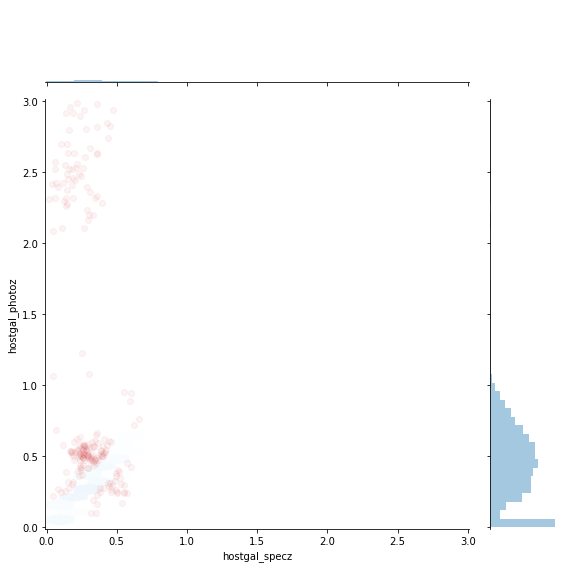

In [224]:
extragal = metadata['hostgal_specz'] != 0.
g = sns.jointplot(metadata['hostgal_specz'][extragal],\
              metadata['hostgal_photoz'][extragal], kind='hex',\
                  xlim=(-0.01, 3.01), ylim=(-0.01,3.01), height=8)

outliers = np.abs(metadata['hostgal_specz'] - metadata['hostgal_photoz']) > 0.1
fig = g.fig
fig.axes[0].scatter(metadata['hostgal_specz'][outliers],\
                    metadata['hostgal_photoz'][outliers], color='C3', alpha=0.05)
fig.tight_layout()

Classes distribution:

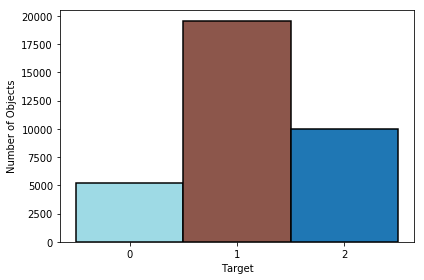

In [15]:
counts = Counter(metadata['target'])
labels = (0, 1, 2)
values = (counts[0], counts[1], counts[2])
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
ax.set_yscale('linear')

fig.tight_layout()

Light curve data:

In [0]:
test_lightcurves_path = './gdrive/My Drive/Colab Notebooks/2019 Summer - Practice/data-my/test_lightcurves_part_1p.csv'

In [0]:
lcdata = Table.read(test_lightcurves_path, format='csv')
lcdata

object_id,mjd,passband,flux,flux_err
int64,float64,int64,float64,float64
1245,60608.14599999999,3,4.554353,1.11344
1245,60611.1227,2,3.35381,0.617947
1500,60356.2189,3,13.28677,1.534637
1500,60356.2298,4,19.69746,2.328523
1500,60359.1234,3,17.089474,1.863271
1500,60359.1344,4,20.730551,2.257219
1500,60370.2006,4,23.389269,3.094382
1500,60373.098,4,19.121988,3.376954
1500,60376.0781,3,13.19377,2.0084


`Timeseries` object using the `cesium` python package for each lightcurve:

In [0]:
mean_flux = np.mean(lcdata['flux'])
mean_flux_error = np.mean(lcdata['flux_err'])

tsdict = OrderedDict()
for i in tnrange(nobjects, desc='Building Timeseries'):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],
            'zerr':row['hostgal_photoz_err'],
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    nones = [1 if np.sum(pb) == 0 else 0 for pb in pbind]
    for pb_id, is_none in enumerate(nones):
        if is_none:
            fake_observ = {}
            fake_observ['object_id'] = thislc[0]['object_id']
            fake_observ['mjd'] = thislc[0]['mjd']
            fake_observ['passband'] = pb_id
            fake_observ['flux'] = mean_flux
            fake_observ['flux_err'] = mean_flux_error
            thislc.add_row(fake_observ)

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,
                                label=target, name=thisid, meta_features=meta,
                                channel_names=pbnames )
    
del lcdata

The list of features available with packages like `cesium` is <a href="http://cesium-ml.org/docs/feature_table.html">huge</a>. We will compute only a subset now:

In [0]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [0]:
import warnings
warnings.simplefilter('ignore')

Feature computation:

In [0]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [0]:
"""
features_list = []
with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
    with multiprocessing.Pool() as pool:  
        results = pool.imap(worker, list(tsdict.values()))
        for res in results:
            features_list.append(res)
            pbar.update()
            
featuretable = featurize.assemble_featureset(features_list=features_list,\
                          time_series=tsdict.values())
"""

In [0]:
# featurize.save_featureset(fset=featuretable, path='./gdrive/My Drive/Colab Notebooks/2019 Summer - Practice/data-my/test_featuretable_part_1p_v2.npz')

In [0]:
featuretable, _ = featurize.load_featureset('./gdrive/My Drive/Colab Notebooks/2019 Summer - Practice/data-my/test_featuretable_part_1p.npz')

The computed feature table has descriptive statistics for each object - a low-dimensional encoding of the information in the light curves. `cesium` assembles it as a `MultiIndex` which does not make `sklearn` happy, so we'll make a simpler table out of it.

In [0]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

Since there's multiple passbands in the data, and the passbands are all sampling the same underlying astrophysical event, it's reasonable to expect that the features we've computed to be correlated. 

To prevent overfitting, it's a probably a good idea to reduce the dimensionality of the dataset. We'll look at this correlation structure.

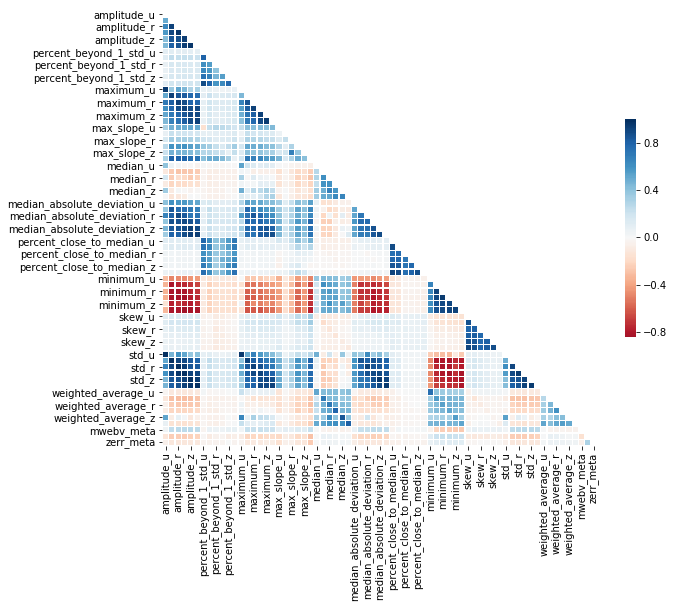

In [19]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

Fill in NaNs and overly large numbers:

In [20]:
nancolnames = ['max_slope_u', 'max_slope_g', 'max_slope_r', 'max_slope_i', 'max_slope_z', 'max_slope_Y']

max_allowed = np.finfo('float64').max / np.power(10, 15)
for i in range(14):
    max_allowed /= np.power(10, 20)

for col in allfeats.colnames:
    allfeats[col] = np.nan_to_num(allfeats[col])
    idx = np.where(allfeats[col] > max_allowed)
    allfeats[col][idx] = max_allowed
    print(col, ':', 'from', np.min(allfeats[col]), 'to', np.max(allfeats[col]))

amplitude_u : from 0.0 to 44341.351494
amplitude_g : from 0.0 to 26062.578369000003
amplitude_r : from 0.0 to 58701.80024699999
amplitude_i : from 0.0 to 32945.957718
amplitude_z : from 0.0 to 51468.3707275
amplitude_Y : from 0.0 to 47241.5615235
percent_beyond_1_std_u : from 0.0 to 0.875
percent_beyond_1_std_g : from 0.0 to 0.9333333333333333
percent_beyond_1_std_r : from 0.0 to 0.9375
percent_beyond_1_std_i : from 0.0 to 0.9375
percent_beyond_1_std_z : from 0.0 to 0.8333333333333334
percent_beyond_1_std_Y : from 0.0 to 0.8888888888888888
maximum_u : from -2065.793945 to 88787.398438
maximum_g : from -9535.251953 to 56482.351562
maximum_r : from -6977.851562000002 to 117728.07031199998
maximum_i : from -6298.038086 to 66194.640625
maximum_z : from -5187.64502 to 100126.328125
maximum_Y : from -2225.808838 to 91045.5
max_slope_u : from 0.0 to 6.190606923482196e+28
max_slope_g : from 0.0 to 6.190606923482196e+28
max_slope_r : from 0.0 to 6.190606923482196e+28
max_slope_i : from 0.0 to 6

In [21]:
np.finfo('float64').max

1.7976931348623157e+308

We'll split the training set into three for training, testing and validation.

In [0]:
Xfull = np.array(allfeats.as_array().tolist())
Yfull = np.array(metadata['target'].tolist())

In [0]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    Xfull, Yfull, test_size=0.2, random_state=20
)

Xtrain, Xval, Ytrain, Yval = train_test_split(
    Xtrain, Ytrain, test_size=0.25, random_state=25
)

In [24]:
Xtrain.shape, Xtest.shape, Xval.shape

((20850, 69), (6951, 69), (6950, 69))

In [25]:
Ytrain.shape, Ytest.shape, Yval.shape

((20850,), (6951,), (6950,))

In [0]:
from tensorflow import keras
from keras.utils import np_utils

Ytrain_dummy = np_utils.to_categorical(Ytrain)
Ytest_dummy = np_utils.to_categorical(Ytest)
Yval_dummy = np_utils.to_categorical(Yval)

In [34]:
Ytrain_dummy.shape, Ytest_dummy.shape, Yval_dummy.shape

((20850, 3), (6951, 3), (6950, 3))

In [0]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(Xfull)
Xtrain_ss = ss.transform(Xtrain)
Xtest_ss = ss.transform(Xtest)
Xval_ss = ss.transform(Xval)

## Random forest classifier

In [67]:
%%time

rfc = RandomForestClassifier(
                             n_estimators=300,
                             criterion='gini',
                             oob_score=True,
                             n_jobs=-1,
                             random_state=42,
                             verbose=1,
                             class_weight='balanced',
                             max_features='sqrt'
                            ).fit(Xtrain, Ytrain)
Ytest_pred_rfc = rfc.predict(Xtest)
Ytest_pred_proba_rfc = rfc.predict_proba(Xtest)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    9.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


CPU times: user 41 s, sys: 259 ms, total: 41.3 s
Wall time: 11.5 s


[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


In [100]:
mylogs = np.log(Ytest_pred_proba_rfc)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_rfc = -np.mean(Ytest_dummy * mylogs)
print("Test loss with RFC: %g" % test_loss_rfc)

Test loss with RFC: 0.134625


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
cm_rfc = confusion_matrix(Ytest, Ytest_pred_rfc, labels=labels)
cm_rfc = cm_rfc.astype('float') / cm_rfc.sum(axis=1)[:, np.newaxis]
annot_rfc = np.around(cm_rfc, 2)

Text(0.5, 1.0, 'random forest classifier, on Xtest')

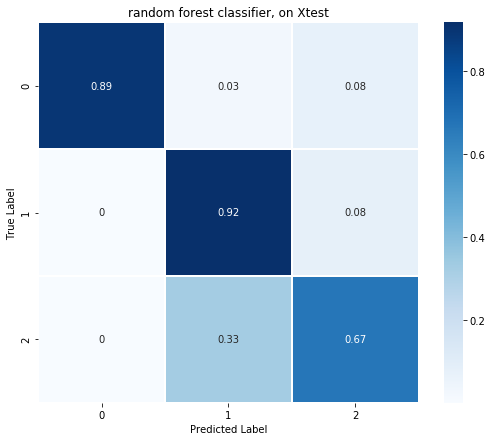

In [84]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_rfc, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_rfc, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('random forest classifier, on Xtest')

## Logistic regression

In [0]:
from sklearn.linear_model import LogisticRegression

### Liblinear

In [86]:
%%time

logreg_liblinear = LogisticRegression(class_weight='balanced',
                                      solver='liblinear',
                                      max_iter=10000,
                                      multi_class='ovr',
                                      verbose=1,
                                      n_jobs=-1
                                     ).fit(Xtrain_ss, Ytrain)
Ytest_pred_logreg_liblinear = logreg_liblinear.predict(Xtest_ss)
Ytest_pred_proba_logreg_liblinear = logreg_liblinear.predict_proba(Xtest_ss)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


[LibLinear]CPU times: user 5.47 s, sys: 20.5 ms, total: 5.49 s
Wall time: 5.49 s


In [101]:
mylogs = np.log(Ytest_pred_proba_logreg_liblinear)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_logreg_liblinear = -np.mean(Ytest_dummy * mylogs)
print("Test loss with logreg (liblinear): %g" % test_loss_logreg_liblinear)

Test loss with logreg (liblinear): 0.254157


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
cm_logreg_liblinear = confusion_matrix(Ytest, Ytest_pred_logreg_liblinear, labels=labels)
cm_logreg_liblinear = cm_logreg_liblinear.astype('float') / cm_logreg_liblinear.sum(axis=1)[:, np.newaxis]
annot_logreg_liblinear = np.around(cm_logreg_liblinear, 2)

Text(0.5, 1.0, 'logreg classifier with liblinear, on Xtest')

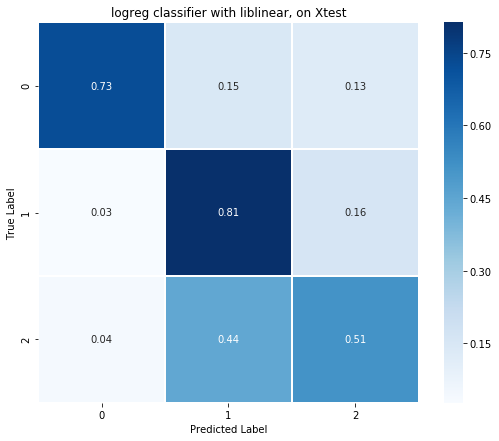

In [91]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_logreg_liblinear, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_logreg_liblinear, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('logreg classifier with liblinear, on Xtest')

### Saga

In [92]:
%%time

logreg_saga = LogisticRegression(class_weight='balanced',
                                      solver='saga',
                                      max_iter=10000,
                                      multi_class='multinomial',
                                      verbose=1,
                                      n_jobs=-1
                                     ).fit(Xtrain_ss, Ytrain)
Ytest_pred_logreg_saga = logreg_saga.predict(Xtest_ss)
Ytest_pred_proba_logreg_saga = logreg_saga.predict_proba(Xtest_ss)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 3683 epochs took 130 seconds
CPU times: user 2min 9s, sys: 24 ms, total: 2min 9s
Wall time: 2min 9s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.2min finished


In [102]:
mylogs = np.log(Ytest_pred_proba_logreg_saga)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_logreg_saga = -np.mean(Ytest_dummy * mylogs)
print("Test loss with logreg (saga): %g" % test_loss_logreg_saga)

Test loss with logreg (saga): 0.253403


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
cm_logreg_saga = confusion_matrix(Ytest, Ytest_pred_logreg_saga, labels=labels)
cm_logreg_saga = cm_logreg_saga.astype('float') / cm_logreg_saga.sum(axis=1)[:, np.newaxis]
annot_logreg_saga = np.around(cm_logreg_saga, 2)

Text(0.5, 1.0, 'logreg classifier with saga, on Xtest')

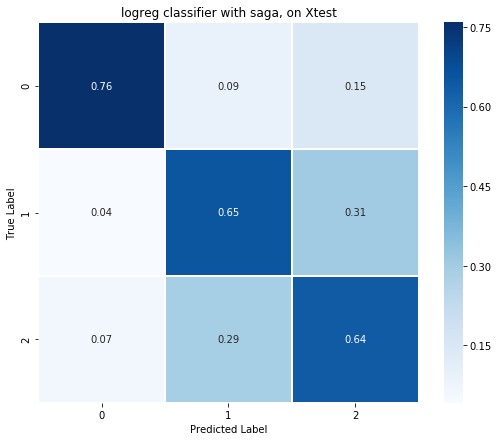

In [95]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_logreg_saga, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_logreg_saga, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('logreg classifier with saga, on Xtest')

### Sag

In [99]:
%%time

logreg_sag = LogisticRegression(class_weight='balanced',
                                      solver='sag',
                                      max_iter=10000,
                                      multi_class='multinomial',
                                      verbose=1,
                                      n_jobs=-1
                                     ).fit(Xtrain_ss, Ytrain)
Ytest_pred_logreg_sag = logreg_sag.predict(Xtest_ss)
Ytest_pred_proba_logreg_sag = logreg_sag.predict_proba(Xtest_ss)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 2778 epochs took 76 seconds
CPU times: user 1min 16s, sys: 19 ms, total: 1min 16s
Wall time: 1min 16s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.3min finished


In [103]:
mylogs = np.log(Ytest_pred_proba_logreg_sag)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_logreg_sag = -np.mean(Ytest_dummy * mylogs)
print("Test loss with logreg (sag): %g" % test_loss_logreg_sag)

Test loss with logreg (sag): 0.254088


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
cm_logreg_sag = confusion_matrix(Ytest, Ytest_pred_logreg_sag, labels=labels)
cm_logreg_sag = cm_logreg_sag.astype('float') / cm_logreg_sag.sum(axis=1)[:, np.newaxis]
annot_logreg_sag = np.around(cm_logreg_sag, 2)

Text(0.5, 1.0, 'logreg classifier with sag, on Xtest')

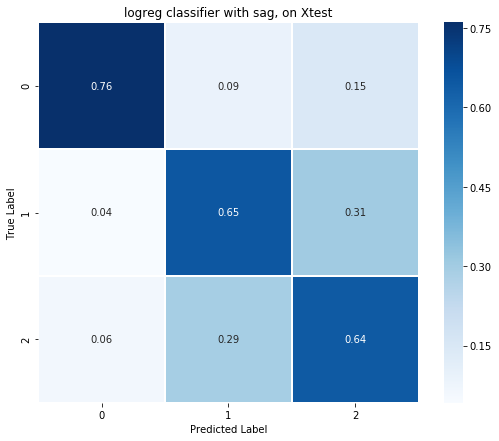

In [105]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_logreg_sag, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_logreg_sag, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('logreg classifier with sag, on Xtest')

### LBFGS

In [106]:
%%time

logreg_lbfgs = LogisticRegression(class_weight='balanced',
                                      solver='lbfgs',
                                      max_iter=10000,
                                      multi_class='multinomial',
                                      verbose=1,
                                      n_jobs=-1
                                     ).fit(Xtrain_ss, Ytrain)
Ytest_pred_logreg_lbfgs = logreg_lbfgs.predict(Xtest_ss)
Ytest_pred_proba_logreg_lbfgs = logreg_lbfgs.predict_proba(Xtest_ss)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 50.9 ms, sys: 87.2 ms, total: 138 ms
Wall time: 12.4 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   12.4s finished


In [107]:
mylogs = np.log(Ytest_pred_proba_logreg_lbfgs)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_logreg_lbfgs = -np.mean(Ytest_dummy * mylogs)
print("Test loss with logreg (lbfgs): %g" % test_loss_logreg_lbfgs)

Test loss with logreg (lbfgs): 0.255009


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
cm_logreg_lbfgs = confusion_matrix(Ytest, Ytest_pred_logreg_lbfgs, labels=labels)
cm_logreg_lbfgs = cm_logreg_lbfgs.astype('float') / cm_logreg_lbfgs.sum(axis=1)[:, np.newaxis]
annot_logreg_lbfgs = np.around(cm_logreg_lbfgs, 2)

Text(0.5, 1.0, 'logreg classifier with lbfgs, on Xtest')

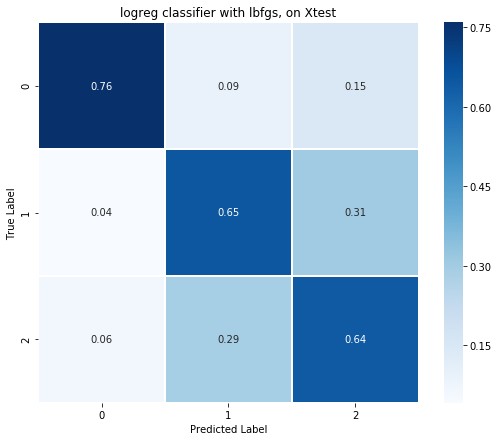

In [109]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_logreg_lbfgs, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_logreg_lbfgs, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('logreg classifier with lbfgs, on Xtest')

### Newton-cg

In [110]:
%%time

logreg_newton = LogisticRegression(class_weight='balanced',
                                      solver='newton-cg',
                                      max_iter=1000,
                                      multi_class='multinomial',
                                      verbose=1,
                                      n_jobs=-1
                                     ).fit(Xtrain_ss, Ytrain)
Ytest_pred_logreg_newton = logreg_newton.predict(Xtest_ss)
Ytest_pred_proba_logreg_newton = logreg_newton.predict_proba(Xtest_ss)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 21.2 ms, sys: 10 ms, total: 31.2 ms
Wall time: 10.6 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   10.6s finished


In [111]:
mylogs = np.log(Ytest_pred_proba_logreg_newton)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_logreg_newton = -np.mean(Ytest_dummy * mylogs)
print("Test loss with logreg (newton): %g" % test_loss_logreg_newton)

Test loss with logreg (newton): 0.255003


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
cm_logreg_newton = confusion_matrix(Ytest, Ytest_pred_logreg_newton, labels=labels)
cm_logreg_newton = cm_logreg_newton.astype('float') / cm_logreg_newton.sum(axis=1)[:, np.newaxis]
annot_logreg_newton = np.around(cm_logreg_newton, 2)

Text(0.5, 1.0, 'logreg classifier with newton, on Xtest')

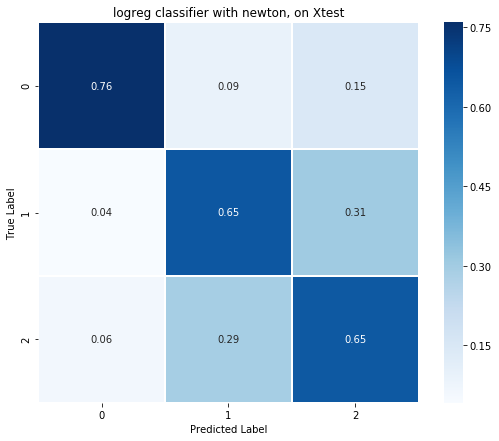

In [113]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_logreg_newton, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_logreg_newton, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('logreg classifier with newton, on Xtest')

## Gradient boosting

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

In [115]:
%%time

gradboost = GradientBoostingClassifier(
                                       learning_rate=0.1,
                                       n_estimators=1000,
                                       verbose=1
                                      ).fit(Xtrain, Ytrain)
Ytest_pred_gradboost = gradboost.predict(Xtest)
Ytest_pred_proba_gradboost = gradboost.predict_proba(Xtest)

      Iter       Train Loss   Remaining Time 
         1       18389.1355            4.60m
         2       17121.3511            4.78m
         3       16134.1017            4.87m
         4       15328.1402            4.92m
         5       14661.2558            4.95m
         6       14092.5735            4.97m
         7       13608.0658            4.95m
         8       13186.0535            4.98m
         9       12786.9230            4.99m
        10       12441.4451            5.01m
        20       10510.1165            4.91m
        30        9658.9162            4.81m
        40        9111.5868            4.77m
        50        8769.5798            4.70m
        60        8487.1257            4.64m
        70        8263.4053            4.60m
        80        8095.9350            4.54m
        90        7947.5983            4.49m
       100        7812.8918            4.43m
       200        6945.2752            3.89m
       300        6349.0051            3.40m
       40

In [116]:
mylogs = np.log(Ytest_pred_proba_gradboost)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_gradboost = -np.mean(Ytest_dummy * mylogs)
print("Test loss with gradboost: %g" % test_loss_gradboost)

Test loss with gradboost: 0.132863


In [0]:
cm_gradboost = confusion_matrix(Ytest, Ytest_pred_gradboost, labels=labels)
cm_gradboost = cm_gradboost.astype('float') / cm_gradboost.sum(axis=1)[:, np.newaxis]
annot_gradboost = np.around(cm_gradboost, 2)

Text(0.5, 1.0, 'gradient boosting classifier, on Xtest')

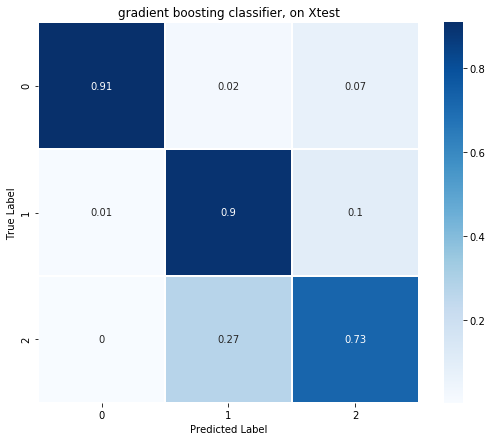

In [118]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_gradboost, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_gradboost, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('gradient boosting classifier, on Xtest')

## K nearest neighbours

In [0]:
from sklearn.neighbors import KNeighborsClassifier

In [120]:
%%time

knn = KNeighborsClassifier(
                           n_neighbors=5,
                           algorithm='auto',
                           weights='distance',
                           p=1,
                           n_jobs=-1
                          ).fit(Xtrain_ss, Ytrain)
Ytest_pred_knn = knn.predict(Xtest_ss)
Ytest_pred_proba_knn = knn.predict_proba(Xtest_ss)

CPU times: user 47.5 s, sys: 10.5 ms, total: 47.5 s
Wall time: 12.5 s


In [121]:
mylogs = np.log(Ytest_pred_proba_knn)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_knn = -np.mean(Ytest_dummy * mylogs)
print("Test loss with kNN: %g" % test_loss_knn)

Test loss with kNN: 0.310374


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [0]:
cm_knn = confusion_matrix(Ytest, Ytest_pred_knn, labels=labels)
cm_knn = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
annot_knn = np.around(cm_knn, 2)

Text(0.5, 1.0, 'kNN classifier, on Xtest')

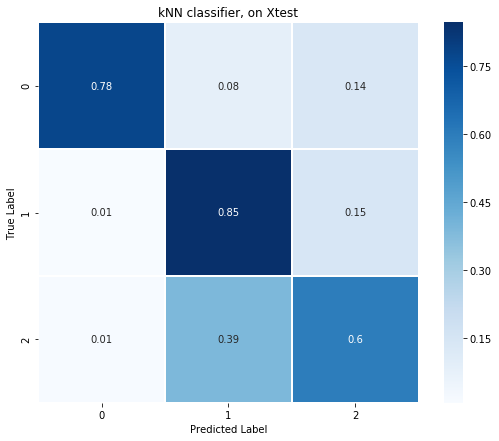

In [123]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_knn, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_knn, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('kNN classifier, on Xtest')

## LGBM Classifier

In [0]:
from lightgbm import LGBMClassifier

In [125]:
%%time

lgbm = LGBMClassifier(
                      boosting_type='dart',
                      learning_rate=0.02,
                      n_estimators=1000,
                      n_jobs=-1
                     ).fit(Xtrain,
                           Ytrain,
                           eval_set=[(Xtest, Ytest)],
                           verbose=50
                          )
Ytest_pred_lgbm = lgbm.predict(Xtest)
Ytest_pred_proba_lgbm = lgbm.predict_proba(Xtest)

[50]	valid_0's multi_logloss: 0.667108
[100]	valid_0's multi_logloss: 0.631502
[150]	valid_0's multi_logloss: 0.603579
[200]	valid_0's multi_logloss: 0.555894
[250]	valid_0's multi_logloss: 0.520839
[300]	valid_0's multi_logloss: 0.488373
[350]	valid_0's multi_logloss: 0.473482
[400]	valid_0's multi_logloss: 0.447116
[450]	valid_0's multi_logloss: 0.428945
[500]	valid_0's multi_logloss: 0.418687
[550]	valid_0's multi_logloss: 0.41129
[600]	valid_0's multi_logloss: 0.411552
[650]	valid_0's multi_logloss: 0.403948
[700]	valid_0's multi_logloss: 0.399669
[750]	valid_0's multi_logloss: 0.396135
[800]	valid_0's multi_logloss: 0.394396
[850]	valid_0's multi_logloss: 0.390087
[900]	valid_0's multi_logloss: 0.387154
[950]	valid_0's multi_logloss: 0.38579
[1000]	valid_0's multi_logloss: 0.383765
CPU times: user 6min 21s, sys: 1.39 s, total: 6min 23s
Wall time: 1min 36s


In [126]:
mylogs = np.log(Ytest_pred_proba_lgbm)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_lgbm = -np.mean(Ytest_dummy * mylogs)
print("Test loss with LGBM: %g" % test_loss_lgbm)

Test loss with LGBM: 0.127922


In [0]:
cm_lgbm = confusion_matrix(Ytest, Ytest_pred_lgbm, labels=labels)
cm_lgbm = cm_lgbm.astype('float') / cm_lgbm.sum(axis=1)[:, np.newaxis]
annot_lgbm = np.around(cm_lgbm, 2)

Text(0.5, 1.0, 'LGBM classifier (dart), on Xtest')

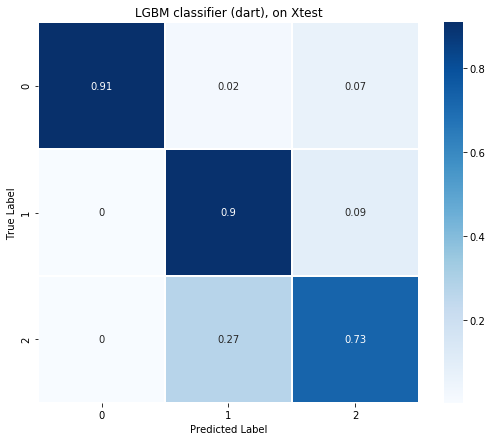

In [128]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_lgbm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_lgbm, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('LGBM classifier (dart), on Xtest')

## Catboost Classifier

In [129]:
!pip install catboost

     |████████████████████████████████| 62.5MB 5.4MB/s 


In [0]:
from catboost import CatBoostClassifier

In [131]:
%%time

catboost = CatBoostClassifier(
                              learning_rate=0.1,
                              verbose=20,
                              n_estimators=500
                             ).fit(Xtrain,
                                   Ytrain
                                  )
Ytest_pred_catboost = catboost.predict(Xtest)
Ytest_pred_proba_catboost = catboost.predict_proba(Xtest)

0:	learn: 1.0086883	total: 262ms	remaining: 2m 10s
20:	learn: 0.5250321	total: 4.44s	remaining: 1m 41s
40:	learn: 0.4511900	total: 8.64s	remaining: 1m 36s
60:	learn: 0.4236328	total: 12.8s	remaining: 1m 32s
80:	learn: 0.4078889	total: 17s	remaining: 1m 27s
100:	learn: 0.3961627	total: 21.1s	remaining: 1m 23s
120:	learn: 0.3839009	total: 25.3s	remaining: 1m 19s
140:	learn: 0.3760592	total: 29.5s	remaining: 1m 15s
160:	learn: 0.3678086	total: 33.6s	remaining: 1m 10s
180:	learn: 0.3607472	total: 37.8s	remaining: 1m 6s
200:	learn: 0.3543662	total: 42s	remaining: 1m 2s
220:	learn: 0.3486914	total: 46.2s	remaining: 58.3s
240:	learn: 0.3439354	total: 50.4s	remaining: 54.1s
260:	learn: 0.3395838	total: 54.5s	remaining: 49.9s
280:	learn: 0.3349037	total: 58.7s	remaining: 45.7s
300:	learn: 0.3313452	total: 1m 2s	remaining: 41.6s
320:	learn: 0.3276085	total: 1m 7s	remaining: 37.4s
340:	learn: 0.3239412	total: 1m 11s	remaining: 33.2s
360:	learn: 0.3206312	total: 1m 15s	remaining: 29s
380:	learn: 0

In [132]:
mylogs = np.log(Ytest_pred_proba_catboost)
infmask = mylogs == -np.inf
mylogs[infmask] = -10

test_loss_catboost = -np.mean(Ytest_dummy * mylogs)
print("Test loss with CatBoost: %g" % test_loss_catboost)

Test loss with CatBoost: 0.126531


In [0]:
cm_catboost = confusion_matrix(Ytest, Ytest_pred_catboost, labels=labels)
cm_catboost = cm_catboost.astype('float') / cm_catboost.sum(axis=1)[:, np.newaxis]
annot_catboost = np.around(cm_catboost, 2)

Text(0.5, 1.0, 'CatBoost classifier, on Xtest')

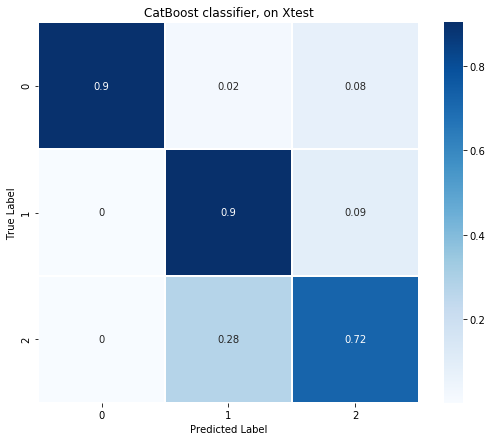

In [134]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm_catboost, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot_catboost, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('CatBoost classifier, on Xtest')

## Classifiers summary

In [0]:
Ytest_pred_proba_union = np.concatenate(
    [
        Ytest_pred_proba_rfc,
        Ytest_pred_proba_logreg_liblinear,
        Ytest_pred_proba_logreg_saga,
        Ytest_pred_proba_logreg_sag,
        Ytest_pred_proba_logreg_lbfgs,
        Ytest_pred_proba_logreg_newton,
        Ytest_pred_proba_gradboost,
        Ytest_pred_proba_knn,
        Ytest_pred_proba_lgbm,
        Ytest_pred_proba_catboost
    ],
    axis=1
)

In [136]:
Ytest_pred_proba_union.shape

(6951, 30)

In [137]:
Xtest.shape

(6951, 69)

## Second classifier: neural network:

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Activation, \
    BatchNormalization, Dropout
from functools import partial
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import np_utils
from time import time

In [0]:
from keras.layers import LeakyReLU


In [140]:
Xtrain_ss.shape, Xtest_ss.shape, Xval_ss.shape

((20850, 69), (6951, 69), (6950, 69))

In [141]:
XYtest_ss = np.concatenate([Xtest_ss, Ytest_pred_proba_union, Ytest_dummy], axis=1)
XYtest_ss.shape

(6951, 102)

In [142]:
Yval_pred_proba_rfc = rfc.predict_proba(Xval)
Yval_pred_proba_logreg_liblinear = logreg_liblinear.predict_proba(Xval_ss)
Yval_pred_proba_logreg_saga = logreg_saga.predict_proba(Xval_ss)
Yval_pred_proba_logreg_sag = logreg_sag.predict_proba(Xval_ss)
Yval_pred_proba_logreg_lbfgs = logreg_lbfgs.predict_proba(Xval_ss)
Yval_pred_proba_logreg_newton = logreg_newton.predict_proba(Xval_ss)
Yval_pred_proba_gradboost = gradboost.predict_proba(Xval)
Yval_pred_proba_knn = knn.predict_proba(Xval_ss)
Yval_pred_proba_lgbm = lgbm.predict_proba(Xval)
Yval_pred_proba_catboost = catboost.predict_proba(Xval)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.2s finished


In [0]:
Yval_pred_proba_union = np.concatenate(
    [
        Yval_pred_proba_rfc,
        Yval_pred_proba_logreg_liblinear,
        Yval_pred_proba_logreg_saga,
        Yval_pred_proba_logreg_sag,
        Yval_pred_proba_logreg_lbfgs,
        Yval_pred_proba_logreg_newton,
        Yval_pred_proba_gradboost,
        Yval_pred_proba_knn,
        Yval_pred_proba_lgbm,
        Yval_pred_proba_catboost
    ],
    axis=1
)

In [144]:
Yval_pred_proba_union.shape, Xval_ss.shape, Yval.shape

((6950, 30), (6950, 69), (6950,))

In [0]:
def test_accuracy(MyNet, X, Y_pred_probas, Y_true_categorical):
    Y_true = np.argmax(Y_true_categorical, axis=1)
    X_for_network = np.concatenate([X, Y_pred_probas], axis=1)
    Y_pred_prob = MyNet.predict(X_for_network)
    Y_pred = np.argmax(Y_pred_prob, axis=1)
    
    current_loss = -np.mean(Y_true_categorical * Y_pred_prob)
    cm = confusion_matrix(Y_true, Y_pred, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annot = np.around(cm, 2)
    return annot, current_loss

In [0]:
def get_tf_dataset(dataset, batch_size):
    N_EXAMPLES = len(dataset)
    shuffler = tf.contrib.data.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    
    dataset_final = suffled_ds.batch(batch_size).prefetch(1)
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset_final)
    return iterator.get_next()

In [147]:
INPUT_SHAPE = Xtest.shape[1] + Ytest_pred_proba_union.shape[1]
INPUT_SHAPE

99

In [220]:
sess = tf.InteractiveSession()

#myactivation = keras.activation.relu

with tf.name_scope("MyNet"):
    MyNet = Sequential(name="MyNet")
    MyNet.add(InputLayer([INPUT_SHAPE]))
    
    MyNet.add(Dense(90))
    MyNet.add(LeakyReLU(alpha=0.1))
    MyNet.add(BatchNormalization())
    MyNet.add(Dropout(0.1))
    
    MyNet.add(Dense(60))
    MyNet.add(LeakyReLU(alpha=0.1))
    MyNet.add(BatchNormalization())
    MyNet.add(Dropout(0.1))
    
    MyNet.add(Dense(30))
    MyNet.add(LeakyReLU(alpha=0.1))
    MyNet.add(BatchNormalization())
    MyNet.add(Dropout(0.1))
    
    MyNet.add(Dense(15))
    MyNet.add(LeakyReLU(alpha=0.1))
    
    MyNet.add(Dense(3, activation=tf.nn.log_softmax))

batch_size = 100
input_data = get_tf_dataset(XYtest_ss, batch_size)
input_x = input_data[:, :-3]
input_x = tf.dtypes.cast(input_x, tf.float32)
input_y = input_data[:, -3:]
input_y = tf.dtypes.cast(input_y, tf.float32)

logprobs = MyNet(input_x)
loss = -tf.reduce_mean(tf.reduce_mean(input_y * logprobs, axis=0))

tf_iter = tf.Variable(initial_value=0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(10e-5, tf_iter, 300, 0.95)

optimiser = tf.group(
    tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=MyNet.trainable_weights),
    tf.assign_add(tf_iter, 1)
)

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(8e3)
t = time()
for iteration in range(TOTAL_ITERATIONS):    
    if iteration % int(5e2) == 0 or iteration == TOTAL_ITERATIONS - 1:
        print("after %d iterations, time %g" % (iteration, time() - t))
        t = time()
        annot_cm, current_loss = test_accuracy(MyNet, Xval_ss, Yval_pred_proba_union, Yval_dummy)
        print("current_loss = %g, time %g" % (current_loss, time() - t))
        print(annot_cm, '\n')
        t = time()
    
    sess.run(optimiser)


after 0 iterations, time 0.000200272
current_loss = 0.358043, time 2.32244
[[0.19 0.54 0.27]
 [0.15 0.55 0.3 ]
 [0.16 0.4  0.44]] 

after 500 iterations, time 4.33089
current_loss = 0.128488, time 0.486539
[[0.9  0.02 0.07]
 [0.   0.91 0.09]
 [0.   0.27 0.73]] 

after 1000 iterations, time 3.67522
current_loss = 0.122488, time 0.489464
[[0.92 0.02 0.07]
 [0.   0.91 0.08]
 [0.   0.26 0.74]] 

after 1500 iterations, time 3.69496
current_loss = 0.12143, time 0.510428
[[0.92 0.02 0.06]
 [0.   0.91 0.09]
 [0.   0.25 0.74]] 

after 2000 iterations, time 3.85067
current_loss = 0.121335, time 0.512688
[[0.92 0.01 0.07]
 [0.   0.9  0.1 ]
 [0.   0.23 0.76]] 

after 2500 iterations, time 3.66492
current_loss = 0.121108, time 0.479789
[[0.92 0.02 0.07]
 [0.   0.92 0.08]
 [0.   0.26 0.73]] 

after 3000 iterations, time 3.652
current_loss = 0.121076, time 0.4809
[[0.92 0.02 0.06]
 [0.   0.91 0.09]
 [0.01 0.25 0.74]] 

after 3500 iterations, time 3.66142
current_loss = 0.121356, time 0.494831
[[0.91 

In [0]:
val_confusion_matrix, final_val_loss = test_accuracy(MyNet, Xval_ss, Yval_pred_proba_union, Yval_dummy)

Final validation loss = 0.122945


Text(0.5, 1.0, 'Final validation results')

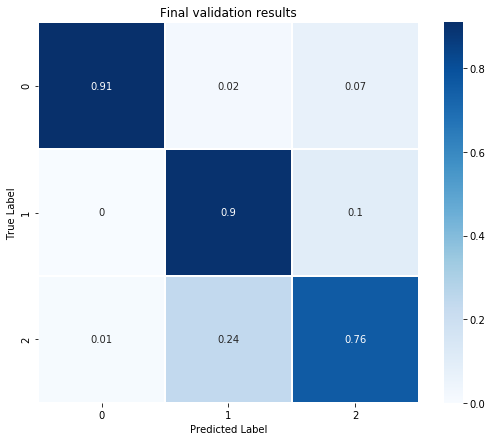

In [222]:
print('Final validation loss = %g' % final_val_loss)

fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(val_confusion_matrix, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=val_confusion_matrix, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')
ax.set_title('Final validation results')

In [0]:
sess.close()

## Neural network:

In [0]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Activation, \
    BatchNormalization, Dropout
from functools import partial
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import np_utils
from time import time

Using TensorFlow backend.


In [0]:
Xtrain_nn = Xtrain.copy()
Xtest_nn = Xtest.copy()
ss = StandardScaler()
ss.fit(Xtrain_nn)
Xtrain_nn = ss.transform(Xtrain_nn)
Xtest_nn = ss.transform(Xtest_nn)

In [0]:
Ytrain_dummy = np_utils.to_categorical(Ytrain)
Ytest_dummy = np_utils.to_categorical(Ytest)

In [0]:
Xtrain_nn.shape, Xtest_nn.shape

((24332, 69), (10429, 69))

In [0]:
XYtrain_nn = np.concatenate([Xtrain_nn, Ytrain_dummy], axis=1)
XYtrain.shape

(24332, 72)

In [0]:
def test_accuracy(MyNet, X, Y, full):
    random_indices = np.random.choice(len(X), len(X) // 10)
    if full:
        random_indices = np.arange(len(X))
    X_fetched = X[random_indices, :]
    Y_true = Y[random_indices]
    Y_pred_prob = MyNet.predict(X_fetched)
    Y_pred = np.argmax(Y_pred_prob, axis=1)
    
    cm = confusion_matrix(Y_true, Y_pred, labels=labels)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    annot = np.around(cm, 2)
    return annot

In [0]:
def get_tf_dataset(dataset, batch_size):
    N_EXAMPLES = len(dataset)
    shuffler = tf.contrib.data.shuffle_and_repeat(N_EXAMPLES)
    dataset_tf = tf.data.Dataset.from_tensor_slices(dataset)
    suffled_ds = shuffler(dataset_tf)
    
    dataset_final = suffled_ds.batch(batch_size).prefetch(1)
    iterator = tf.compat.v1.data.make_one_shot_iterator(dataset_final)
    return iterator.get_next()

In [0]:
sess = tf.InteractiveSession()

#myactivation = keras.activation.relu

with tf.name_scope("MyNet"):
    MyNet = Sequential(name="MyNet")
    MyNet.add(InputLayer([Xtrain.shape[1]]))
    
    MyNet.add(Dense(120))
    MyNet.add(Activation('relu'))
    MyNet.add(BatchNormalization())
    MyNet.add(Dropout(0.2))
    
    MyNet.add(Dense(90))
    MyNet.add(Activation('relu'))
    MyNet.add(BatchNormalization())
    MyNet.add(Dropout(0.2))
    
    MyNet.add(Dense(60))
    MyNet.add(Activation('relu'))
    MyNet.add(BatchNormalization())
    MyNet.add(Dropout(0.2))
    
    MyNet.add(Dense(30))
    MyNet.add(Activation('relu'))
    MyNet.add(BatchNormalization())
    MyNet.add(Dropout(0.2))
    
    MyNet.add(Dense(15))
    MyNet.add(Activation('relu'))
    
    MyNet.add(Dense(3, activation=tf.nn.log_softmax))

batch_size = 100
input_data = get_tf_dataset(XYtrain_nn, batch_size)
input_x = input_data[:, :-3]
input_x = tf.dtypes.cast(input_x, tf.float32)
input_y = input_data[:, -3:]
input_y = tf.dtypes.cast(input_y, tf.float32)

logprobs = MyNet(input_x)
loss = -tf.reduce_mean(tf.reduce_mean(input_y * logprobs, axis=0))

learning_rate = 1e-5
optimiser = tf.train.AdamOptimizer(learning_rate).minimize(
    loss, var_list=MyNet.trainable_weights
)

sess.run(tf.global_variables_initializer())

TOTAL_ITERATIONS = int(1e5)
t = time()
for epoch in range(TOTAL_ITERATIONS):
    sess.run(optimiser)
    
    if epoch % int(5e3) == 0:
        print("epoch = %d, time %g" % (epoch, time() - t))
        t = time()
        annot_cm = test_accuracy(MyNet, Xtest_nn, Ytest, False)
        print("confusions matrix, time %g" % (time() - t))
        print(annot_cm, '\n')
        t = time()


epoch = 0, time 0.431174
confusions matrix, time 1.7322
[[0.01 0.14 0.86]
 [0.   0.   1.  ]
 [0.   0.01 0.99]] 

epoch = 5000, time 41.9734
confusions matrix, time 0.0683427
[[0.62 0.22 0.16]
 [0.   0.38 0.62]
 [0.01 0.07 0.92]] 

epoch = 10000, time 41.6205
confusions matrix, time 0.0685444
[[0.7  0.16 0.14]
 [0.01 0.52 0.47]
 [0.02 0.12 0.87]] 

epoch = 15000, time 41.5727
confusions matrix, time 0.0657139
[[0.79 0.13 0.08]
 [0.02 0.6  0.37]
 [0.01 0.12 0.87]] 

epoch = 20000, time 41.3757
confusions matrix, time 0.0714655
[[0.8  0.16 0.05]
 [0.02 0.58 0.41]
 [0.01 0.09 0.9 ]] 

epoch = 25000, time 41.7135
confusions matrix, time 0.0678713
[[0.86 0.09 0.05]
 [0.01 0.66 0.33]
 [0.   0.12 0.87]] 

epoch = 30000, time 41.5027
confusions matrix, time 0.0670345
[[0.76 0.15 0.09]
 [0.   0.65 0.35]
 [0.   0.11 0.89]] 

epoch = 35000, time 41.9206
confusions matrix, time 0.0665195
[[0.81 0.09 0.1 ]
 [0.03 0.65 0.32]
 [0.01 0.13 0.86]] 

epoch = 40000, time 41.4928
confusions matrix, time 0.0

In [0]:
test_confusion_matrix = test_accuracy(MyNet, Xtest_nn, Ytest, True)

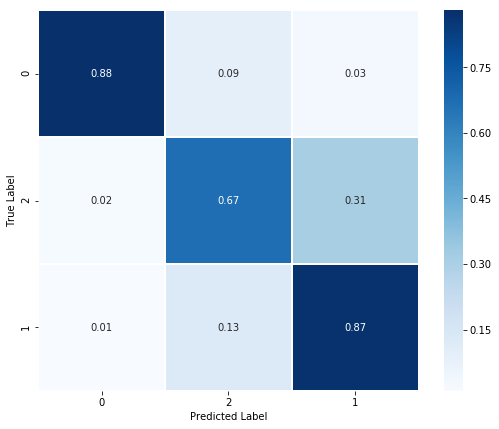

In [0]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(test_confusion_matrix, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=test_confusion_matrix, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

In [0]:
sess.close()